In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

pd.set_option('display.max_columns', None)
plt.rcParams['figure.figsize'] = (12,6)

# Predicting Phishing Web Page Using Machine Learning

Phishing is a method of trying to gather personal information using deceptive e-mails and websites.

In this notebook, we will read the data and look at what are the features that can give us information on what are the attributes of a phishing website

# Loading the data

We will start by loading the provided csv data using pandas read_csv method

In [2]:
data = pd.read_csv("Phishing_Legitimate_full.csv")

# Convert data

In this phase we will convert float64 and int64 data to type 32, by doing this we can save the memory usage and we can prepare the data for using with CuML later for training purpose

As we can see the data has 10k rows and 50 columns including labels

In [3]:
float_cols = data.select_dtypes('float64').columns
for c in float_cols:
    data[c] = data[c].astype('float32')

int_cols = data.select_dtypes('int64').columns
for c in int_cols:
    data[c] = data[c].astype('int32')

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 50 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   id                                  10000 non-null  int32  
 1   NumDots                             10000 non-null  int32  
 2   SubdomainLevel                      10000 non-null  int32  
 3   PathLevel                           10000 non-null  int32  
 4   UrlLength                           10000 non-null  int32  
 5   NumDash                             10000 non-null  int32  
 6   NumDashInHostname                   10000 non-null  int32  
 7   AtSymbol                            10000 non-null  int32  
 8   TildeSymbol                         10000 non-null  int32  
 9   NumUnderscore                       10000 non-null  int32  
 10  NumPercent                          10000 non-null  int32  
 11  NumQueryComponents                  10000 

In [4]:
data.rename(columns={'CLASS_LABEL': 'labels'}, inplace=True)

# View the data

Lets look at random 5 rows from the dataset, it seems like we have mix of ranged data, some column have smaller range compared to others

In [5]:
data.sample(5)

,id,NumDots,SubdomainLevel,PathLevel,UrlLength,NumDash,NumDashInHostname,AtSymbol,TildeSymbol,NumUnderscore,NumPercent,NumQueryComponents,NumAmpersand,NumHash,NumNumericChars,NoHttps,RandomString,IpAddress,DomainInSubdomains,DomainInPaths,HttpsInHostname,HostnameLength,PathLength,QueryLength,DoubleSlashInPath,NumSensitiveWords,EmbeddedBrandName,PctExtHyperlinks,PctExtResourceUrls,ExtFavicon,InsecureForms,RelativeFormAction,ExtFormAction,AbnormalFormAction,PctNullSelfRedirectHyperlinks,FrequentDomainNameMismatch,FakeLinkInStatusBar,RightClickDisabled,PopUpWindow,SubmitInfoToEmail,IframeOrFrame,MissingTitle,ImagesOnlyInForm,SubdomainLevelRT,UrlLengthRT,PctExtResourceUrlsRT,AbnormalExtFormActionR,ExtMetaScriptLinkRT,PctExtNullSelfRedirectHyperlinksRT,labels
3125,3126,3,1,8,191,4,1,0,0,0,0,1,0,0,58,1,1,0,0,1,0,20,126,37,0,0,0,0.000000,0.041667,1,1,0,0,0,0.0,0,0,0,0,0,0,0,0,1,-1,1,1,0,1,1
9273,9274,3,1,3,56,0,0,0,0,0,0,0,0,0,2,1,0,0,0,0,0,19,30,0,0,0,0,0.246914,0.789474,0,1,0,1,0,0.0,0,0,0,0,0,1,0,0,1,0,-1,0,0,1,0
1480,1481,4,1,4,60,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,27,26,0,0,0,0,1.000000,1.000000,0,1,0,0,0,0.0,1,0,0,0,0,0,0,0,1,0,-1,1,-1,-1,1
2246,2247,2,0,5,70,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,13,50,0,0,0,0,1.000000,0.142857,1,1,0,0,0,0.0,0,0,0,0,0,1,0,0,1,0,1,1,0,-1,1
8367,8368,2,1,3,53,3,0,0,0,0,0,0,0,0,3,1,0,0,0,1,0,20,26,0,0,0,0,0.113208,0.975610,1,0,0,0,0,0.0,0,0,0,0,0,0,0,0,1,1,-1,1,0,1,0


# Summary Statistics

By using the describe method, we can see some of the columns have high variance and some have smaller variance, this is due to the fact that some of the column have bigger values and bigger ranges

In [6]:
data.describe()

,id,NumDots,SubdomainLevel,PathLevel,UrlLength,NumDash,NumDashInHostname,AtSymbol,TildeSymbol,NumUnderscore,NumPercent,NumQueryComponents,NumAmpersand,NumHash,NumNumericChars,NoHttps,RandomString,IpAddress,DomainInSubdomains,DomainInPaths,HttpsInHostname,HostnameLength,PathLength,QueryLength,DoubleSlashInPath,NumSensitiveWords,EmbeddedBrandName,PctExtHyperlinks,PctExtResourceUrls,ExtFavicon,InsecureForms,RelativeFormAction,ExtFormAction,AbnormalFormAction,PctNullSelfRedirectHyperlinks,FrequentDomainNameMismatch,FakeLinkInStatusBar,RightClickDisabled,PopUpWindow,SubmitInfoToEmail,IframeOrFrame,MissingTitle,ImagesOnlyInForm,SubdomainLevelRT,UrlLengthRT,PctExtResourceUrlsRT,AbnormalExtFormActionR,ExtMetaScriptLinkRT,PctExtNullSelfRedirectHyperlinksRT,labels
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.0,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.0000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5000.50000,2.445100,0.586800,3.300300,70.264100,1.818000,0.138900,0.000300,0.013100,0.32320,0.073800,0.458600,0.277200,0.002300,5.810300,0.988800,0.52520,0.017200,0.022200,0.428900,0.0,18.82430,35.564900,8.606500,0.000900,0.109300,0.057100,0.241334,0.392932,0.167200,0.844000,0.248700,0.1018,0.057600,0.136136,0.215300,0.005500,0.014000,0.004900,0.128800,0.339600,0.03220,0.030400,0.956600,0.020200,0.353300,0.793200,0.173400,0.314100,0.500000
std,2886.89568,1.346836,0.751214,1.863241,33.369877,3.106258,0.545744,0.017319,0.113709,1.11466,0.622248,1.344793,1.117356,0.047906,9.617877,0.105241,0.49939,0.130023,0.147341,0.494944,0.0,8.11654,24.588502,24.313053,0.029988,0.368737,0.232045,0.342363,0.387295,0.373173,0.362873,0.432281,0.3024,0.232997,0.312426,0.411051,0.073961,0.117496,0.069832,0.334995,0.473597,0.17654,0.171694,0.248037,0.820036,0.888908,0.521019,0.755771,0.897843,0.500025
min,1.00000,1.000000,0.000000,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,4.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
25%,2500.75000,2.000000,0.000000,2.000000,48.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.0,14.00000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.030303,0.000000,1.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,1.000000,-1.000000,-1.000000,1.000000,0.000000,-1.000000,0.000000
50%,5000.50000,2.000000,1.000000,3.000000,62.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000,1.00000,0.000000,0.000000,0.000000,0.0,18.00000,30.000000,0.000000,0.000000,0.000000,0.000000,0.071429,0.247511,0.000000,1.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.500000
75%,7500.25000,3.000000,1.000000,4.000000,84.000000,2.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,8.000000,1.000000,1.00000,0.000000,0.000000,1.000000,0.0,22.00000,48.000000,0.000000,0.000000,0.000000,0.000000,0.315874,0.785714,0.000000,1.000000,0.000000,0.0000,0.000000,0.047619,0.000000,0.000000,0.000000,0.000

# Balance/Imbalanced Data

The data is balanced for non-phising and phising label

<Axes: xlabel='labels'>

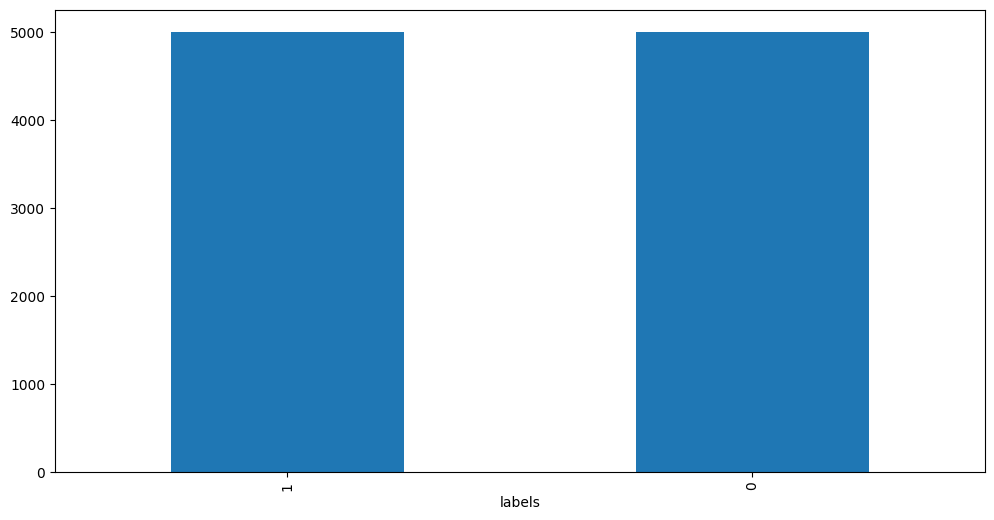

In [7]:
data['labels'].value_counts().plot(kind='bar')

# Spearman Correlation

By looking the spearman correlation, we can find which features are linearly correlated in terms of predicting if a site is phising or not

In [8]:
def corr_heatmap(data, idx_s, idx_e):
    y = data['labels']
    temp = data.iloc[:, idx_s:idx_e]
    if 'id' in temp.columns:
        del temp['id']
    temp['labels'] = y
    sns.heatmap(temp.corr(), annot=True, fmt='.2f')
    plt.show()

## First 10 columns

By looking at the first 10 columns against labels, we can concluded that non of the features have strong correlation with the labels, however, NumDash has some significant negative effect towards the labels, which could mean if there is less number of dash then it is more likely to be phising site

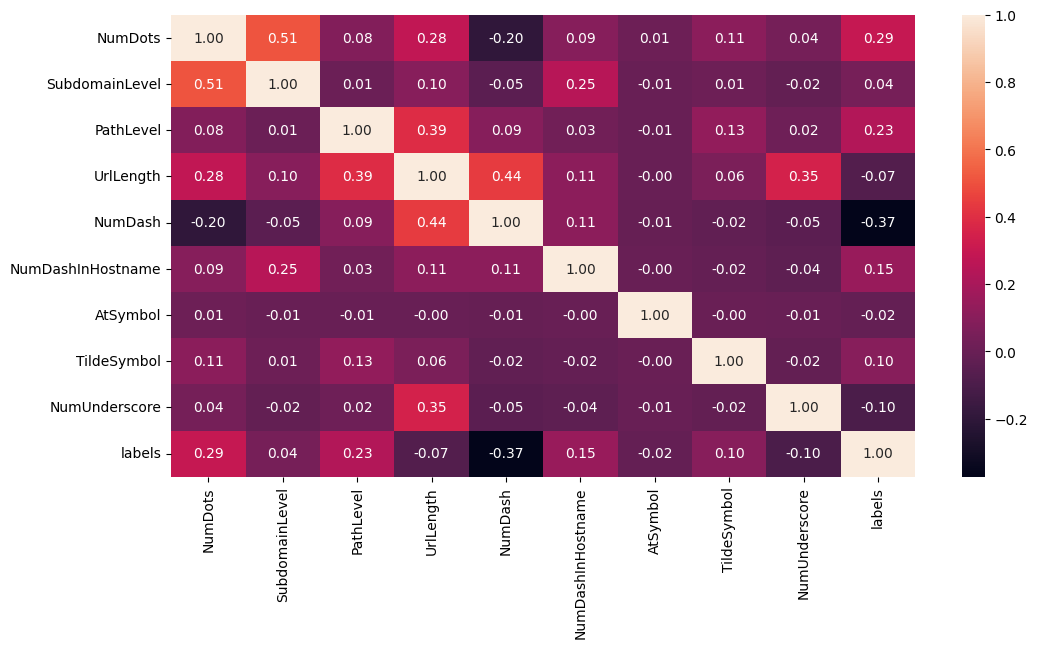

In [9]:
corr_heatmap(data, 0, 10)

## Columns 10 to 20

There are no strong or even medium level strength correlation features with labels

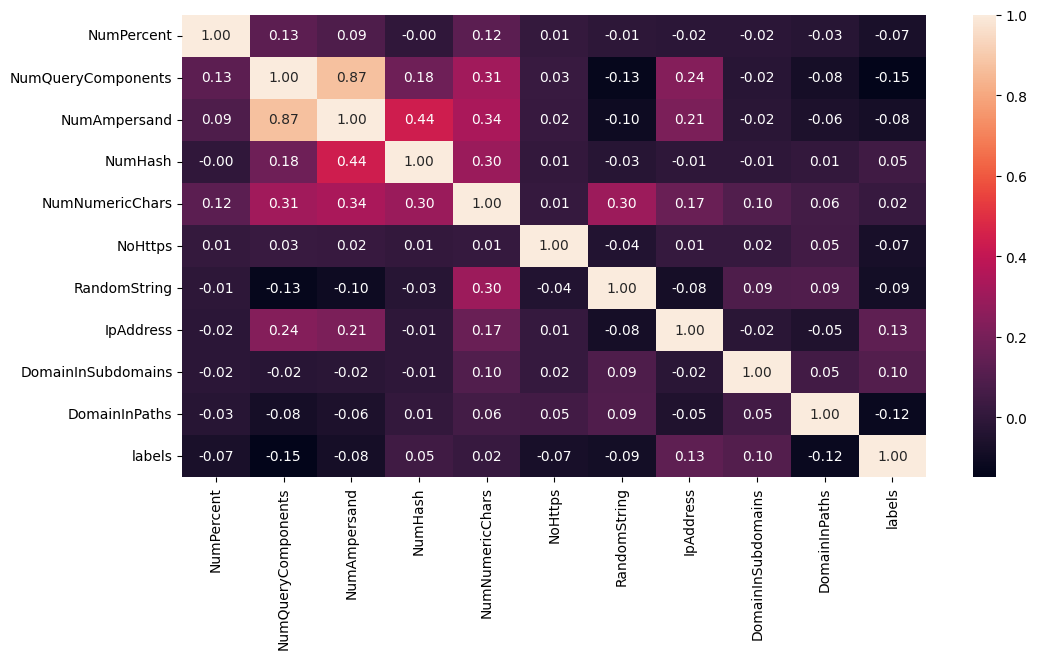

In [10]:
corr_heatmap(data, 10, 20)

## Columns 20 to 30

Still no strong correlation feature

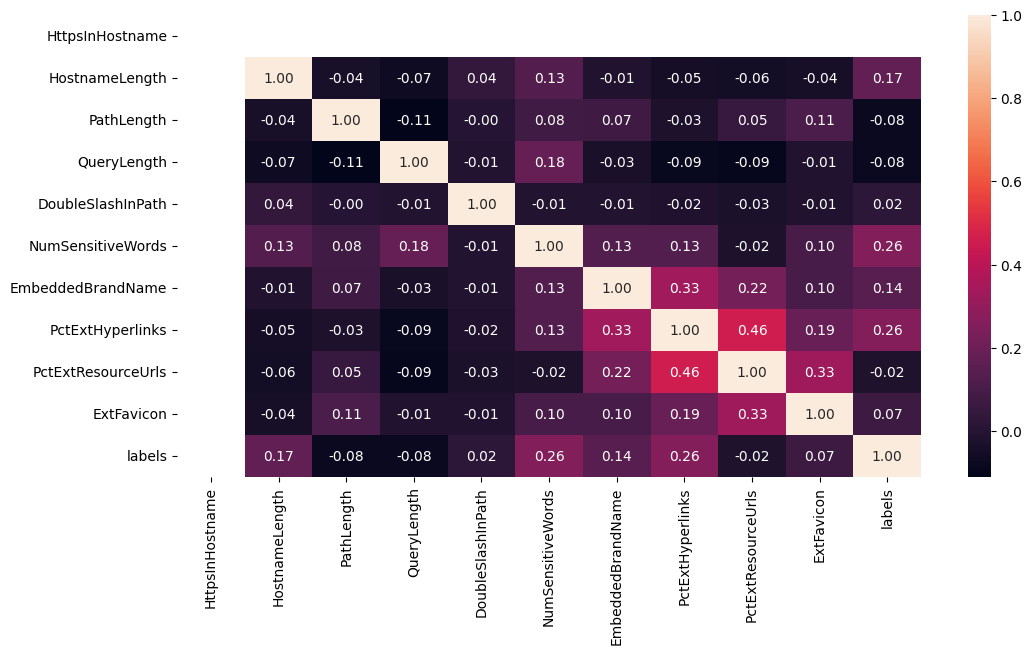

In [11]:
corr_heatmap(data, 20, 30)

## Columns 30 to 40

Well here we have a few features that are linearly correlated to our dep variable

* InsecureForms shows that as the value is higher so the probability of being a phising site
* PctNullSelfRedirectHyperlinks shows the same positive correlation as InsecureForms
* FequentDomainNameMismatch shows that it has medium linear correlation in positive direction
* SubmitInfoToEmail seems to indicate that sites that ask users to submit their details to emails seems to be more high probability for phising

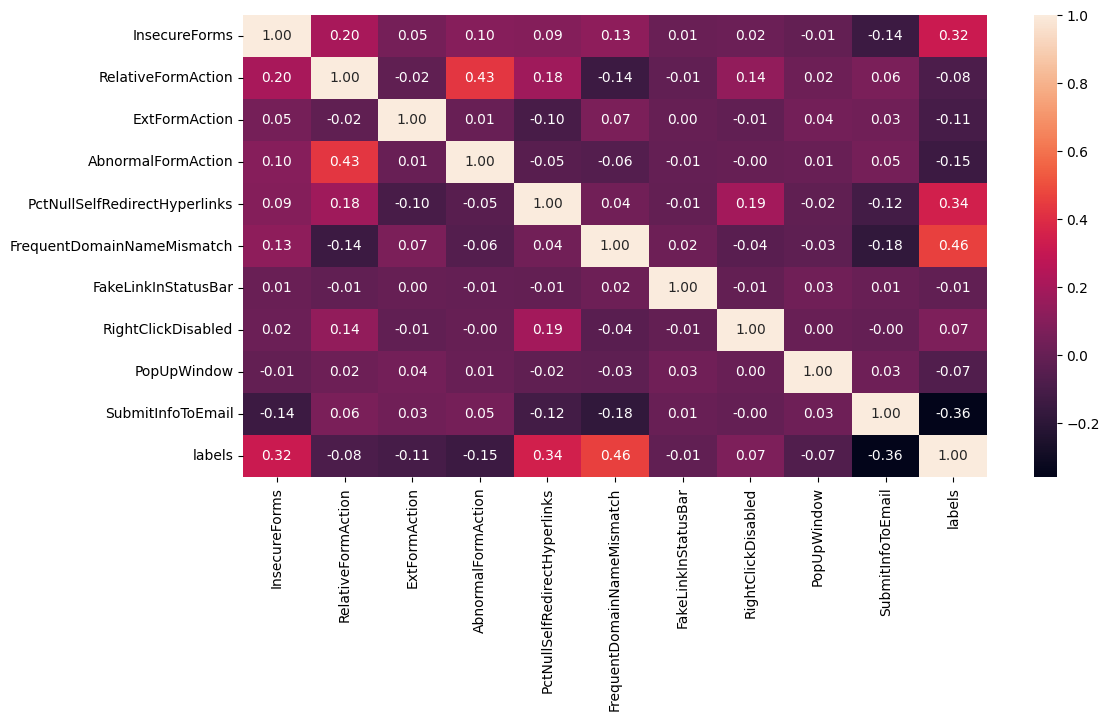

In [12]:
corr_heatmap(data, 30, 40)

## Columsn 40 to 50

The only column in this group that has some correlation with labels is PctExtNullSelfRedirectHyperlinksRT and it has negative effect towards labels which could mean that when the number of percent of null self redirect hyperlinks occur hence the probabiliy of phising increases

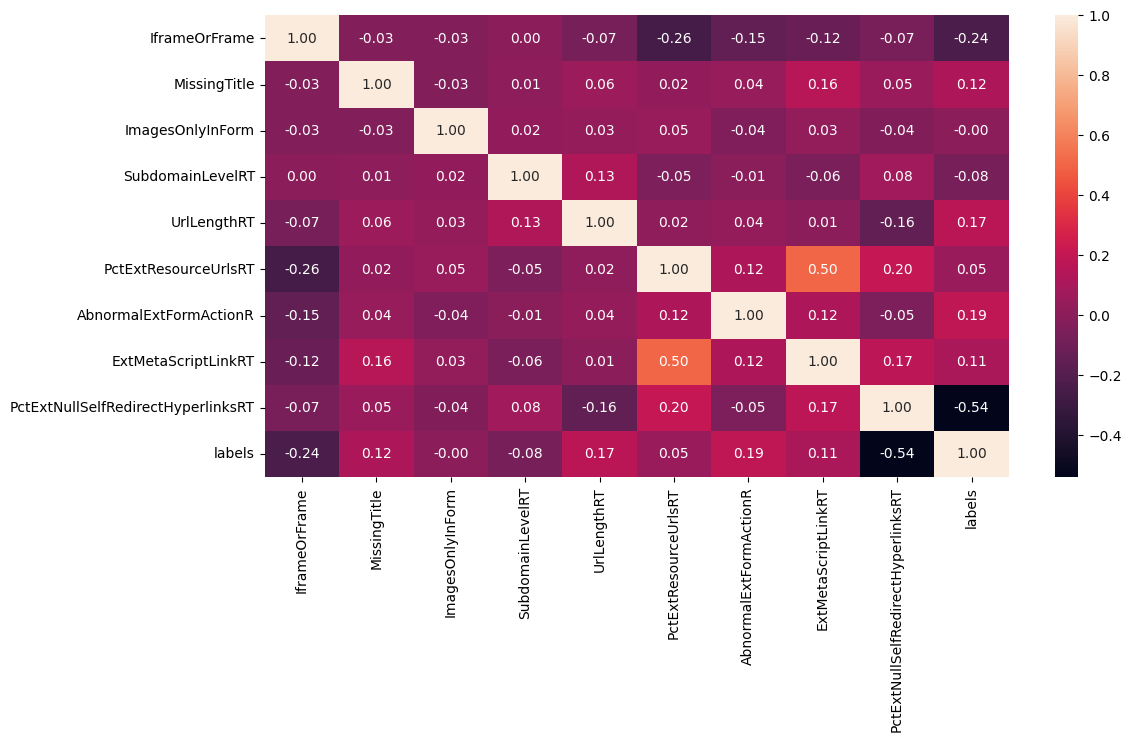

In [13]:
corr_heatmap(data, 40, 50)

# Mutual Info

We will use mutual info classifier to find non linear and linear correlation betweem the features and labels

In [14]:
from sklearn.feature_selection import mutual_info_classif

In [15]:
X = data.drop(['id', 'labels'], axis=1)
y = data['labels']

In [16]:
discrete_features = X.dtypes == int

Here we process the scores and we can see that now mutual info is showing a bit different list from spearman corr

In [17]:
mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features)
mi_scores = pd.Series(mi_scores, name='MI Scores', index=X.columns)
mi_scores = mi_scores.sort_values(ascending=False)
mi_scores

,MI Scores
PctExtHyperlinks,0.467498
PctExtResourceUrls,0.292972
PctNullSelfRedirectHyperlinks,0.237038
PctExtNullSelfRedirectHyperlinksRT,0.218939
FrequentDomainNameMismatch,0.130657
NumNumericChars,0.129784
ExtMetaScriptLinkRT,0.122731
NumDash,0.103015
SubmitInfoToEmail,0.077450
PathLevel,0.066676


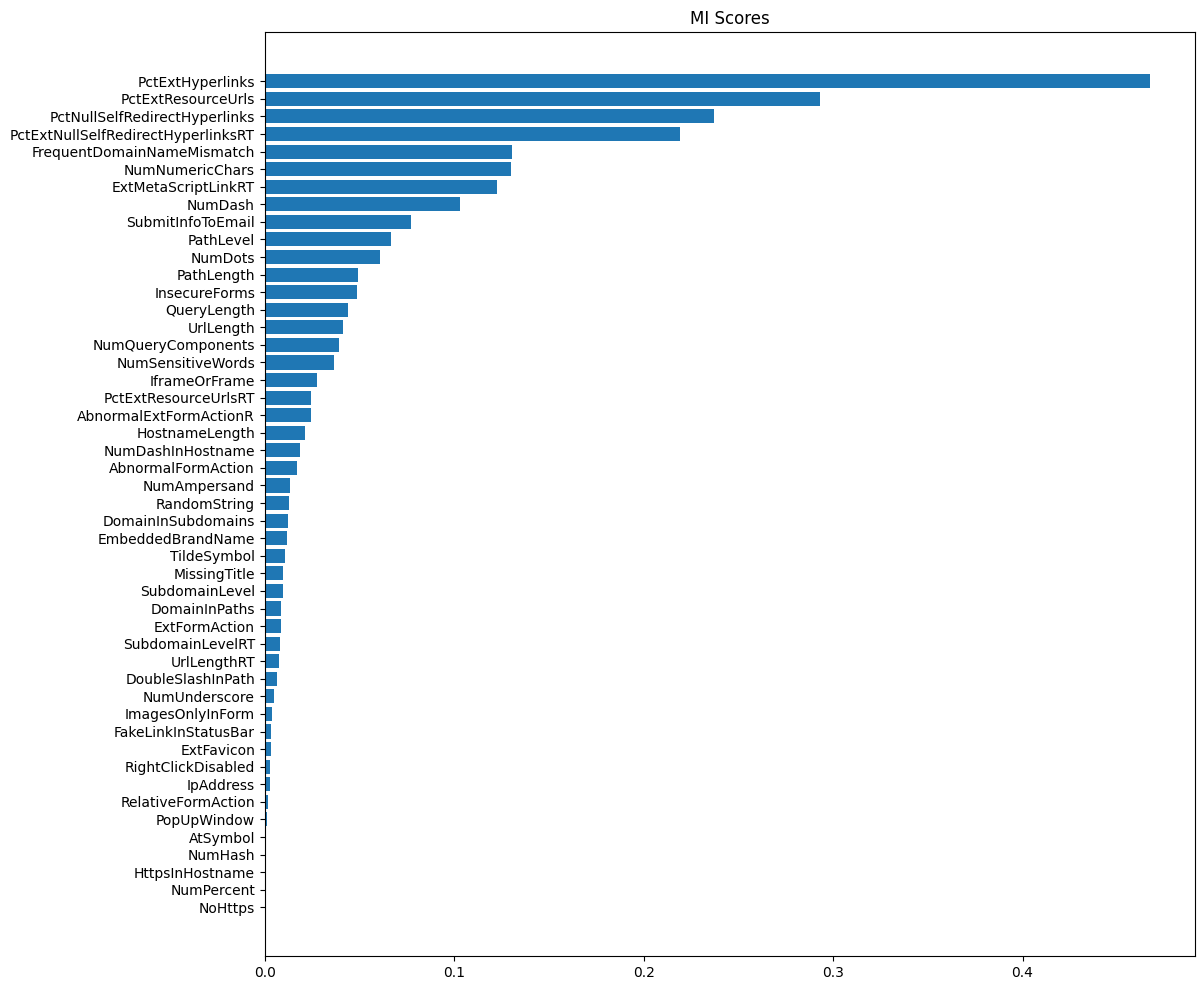

In [18]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("MI Scores")

plt.figure(dpi=100, figsize=(12,12))
plot_mi_scores(mi_scores)

# Prediction

We will first use logistic regression as for baseline, then try to beat the baseline using random forest classifer

Our evaluation metrics will be accuracy, precision, recall and f1 score

Below we import all the required modules

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier as cuRfc
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# **LOGISTIC MODEL**

## Train logistic models

This method is to perform a repetative training process using logistic regression model, the purpose for this is to find the optimal number of features that can be used to find the best fitted model without adjusting much of the hyperparameters, hence the idea here is to go with Data-Centric training, basically the method takes number of top N features to be used for training the model and all the evaluation metrics are returned for evaluation purpose

In [20]:
def train_logistic(data, top_n):
    top_n_features = mi_scores.sort_values(ascending=False).head(top_n).index.tolist()
    X = data[top_n_features]
    y = data['labels']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    lr = LogisticRegression(max_iter=10000)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_test)

    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)

    return precision, recall, f1, accuracy

Here the loop will be starting from 20 as we will start training with top 20 features up to all 50 features to find optimal number of features needed for this problem

In [21]:
arrlr = []
for i in range(20,51,1):
    precision, recall, f1, accuracy = train_logistic(data, i)
    print("Performance for Logistic Model with Top {} features is precision : {}, recall : {}, f1 score : {}, accuracy : {}".format(i, precision, recall, f1, accuracy))
    arrlr.append([i, precision, recall, f1, accuracy])

Performance for Logistic Model with Top 20 features is precision : 0.9309664694280079, recall : 0.932806324110672, f1 score : 0.9318854886475815, accuracy : 0.931
Performance for Logistic Model with Top 21 features is precision : 0.9310344827586207, recall : 0.9337944664031621, f1 score : 0.9324124321657622, accuracy : 0.9315
Performance for Logistic Model with Top 22 features is precision : 0.9253875968992248, recall : 0.9436758893280632, f1 score : 0.9344422700587084, accuracy : 0.933
Performance for Logistic Model with Top 23 features is precision : 0.9262135922330097, recall : 0.9426877470355731, f1 score : 0.9343780607247796, accuracy : 0.933
Performance for Logistic Model with Top 24 features is precision : 0.9296875, recall : 0.9407114624505929, f1 score : 0.9351669941060904, accuracy : 0.934
Performance for Logistic Model with Top 25 features is precision : 0.9305962854349951, recall : 0.9407114624505929, f1 score : 0.9356265356265356, accuracy : 0.9345
Performance for Logistic

## Visualize Logistic Reg Performance

As we can see, the model had ups and downs during the training as more number of features were added, as our target is to maximize all the metrics we have to find the number of features that gives us the best of all metrics, from the figure below, we can see that recall is constantly performing good but our model tend to have problem with precision score, hence to choose the best N of features, we have to pick the area where all the metrics are performing and based on the figure I would say its around 36 features

In [22]:
# Assuming 'arr' is the list of results from your training loop
df_resultslr = pd.DataFrame(arrlr, columns=['num_of_features', 'Precision', 'Recall', 'F1 Score', 'Accuracy'])


<Axes: xlabel='num_of_features', ylabel='Precision'>

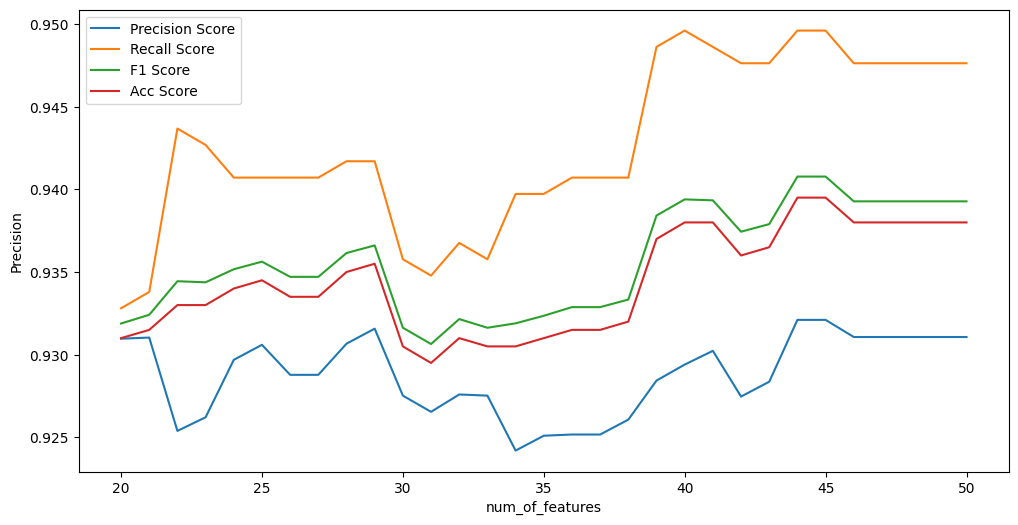

In [23]:
sns.lineplot(x='num_of_features', y='Precision', data=df_resultslr, label='Precision Score')
sns.lineplot(x='num_of_features', y='Recall', data=df_resultslr, label='Recall Score')
sns.lineplot(x='num_of_features', y='F1 Score', data=df_resultslr, label='F1 Score')
sns.lineplot(x='num_of_features', y='Accuracy', data=df_resultslr, label='Acc Score')

In [24]:
# Sort by accuracy in descending order and display the top 3
top_3_resultslr = df_resultslr.sort_values('Accuracy', ascending=False).head(3)

top_3_resultslr


,num_of_features,Precision,Recall,F1 Score,Accuracy
25,45,0.932105,0.949605,0.940773,0.9395
24,44,0.932105,0.949605,0.940773,0.9395
30,50,0.931068,0.947628,0.939275,0.9380


## Final Logistic Regression Model

Lets train the final random forest model based on the optimal N number of features

In [28]:
top_n_featureslr = mi_scores.sort_values(ascending=False).head(45).index.tolist()

# Prepare the data with selected features
X = data[top_n_featureslr]
y = data['labels']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the logistic regression model
lr = LogisticRegression(max_iter=10000)
lr.fit(X_train, y_train)

# Make predictions on the test set
y_predlr = lr.predict(X_test)

# Evaluate the model
accuracy_lr = accuracy_score(y_test, y_predlr)
precision_lr = precision_score(y_test, y_predlr)
recall_lr = recall_score(y_test, y_predlr)
f1_lr = f1_score(y_test, y_predlr)
conf_matrix_lr = confusion_matrix(y_test, y_predlr)
class_report_lr = classification_report(y_test, y_predlr)

# Print the results
print(f'Single Classifier Logistic Regression Original')
print(f'Accuracy: {accuracy_lr}')
print(f'Precision: {precision_lr}')
print(f'Recall: {recall_lr}')
print(f'F1 Score: {f1_lr}')
print(f'Confusion Matrix:')
print(conf_matrix_lr)
print(class_report_lr)

Single Classifier Logistic Regression Original
Accuracy: 0.9395
Precision: 0.9321047526673133
Recall: 0.9496047430830039
F1 Score: 0.9407733724914341
Confusion Matrix:
[[918  70]
 [ 51 961]]
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       988
           1       0.93      0.95      0.94      1012

    accuracy                           0.94      2000
   macro avg       0.94      0.94      0.94      2000
weighted avg       0.94      0.94      0.94      2000



# **Random Forest Classifier**

## Training Random Forest Classifier on GPU

It is the same method as logistic reg, the only diff is that we are now using random forest classifier for training and trying to beat the logistic baseline

In [29]:
def train_rfc(data, top_n):
    top_n_features = mi_scores.sort_values(ascending=False).head(top_n).index.tolist()
    X = data[top_n_features]
    y = data['labels']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    rfc = cuRfc(n_estimators=500,
                max_depth=32,
                min_samples_leaf=1,
                max_features=1.0)

    rfc.fit(X_train, y_train)

    y_pred = rfc.predict(X_test)

    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)

    return precision, recall, f1, accuracy

In [30]:
arrrf = []
for i in range(20,51,1):
    precision, recall, f1, accuracy = train_rfc(data, i)
    print("Performance for RFC Model with Top {} features is precision : {}, recall : {}, f1 score : {}, accuracy : {}".format(i, precision, recall, f1, accuracy))
    arrrf.append([i, precision, recall, f1, accuracy])

Performance for RFC Model with Top 20 features is precision : 0.9754420432220039, recall : 0.9812252964426877, f1 score : 0.9783251231527094, accuracy : 0.978
Performance for RFC Model with Top 21 features is precision : 0.97534516765286, recall : 0.9772727272727273, f1 score : 0.9763079960513327, accuracy : 0.976
Performance for RFC Model with Top 22 features is precision : 0.9734251968503937, recall : 0.9772727272727273, f1 score : 0.97534516765286, accuracy : 0.975
Performance for RFC Model with Top 23 features is precision : 0.9752964426877471, recall : 0.9752964426877471, f1 score : 0.9752964426877471, accuracy : 0.975
Performance for RFC Model with Top 24 features is precision : 0.9743589743589743, recall : 0.9762845849802372, f1 score : 0.9753208292201382, accuracy : 0.975
Performance for RFC Model with Top 25 features is precision : 0.9743336623889437, recall : 0.9752964426877471, f1 score : 0.9748148148148148, accuracy : 0.9745
Performance for RFC Model with Top 26 features is

## Visualize Random Forest Performance

Our goal is to beat logistic regression baseline which is

* accuracy = 0.9395
* precision = 0.933788
* recall = 0.947628
* f1_score = 0.940657

So by visualizing the figure below, we can conclude that the best number of features for this model would be 32, one less than logistic regression, the reason why I chose 32 is because that is the number of features that allowed the model to perform the best across all the evaluation metric

In [34]:
df_resultsrf = pd.DataFrame(arrrf, columns=['num_of_features', 'precision', 'recall', 'f1_score', 'accuracy'])

<Axes: xlabel='num_of_features', ylabel='precision'>

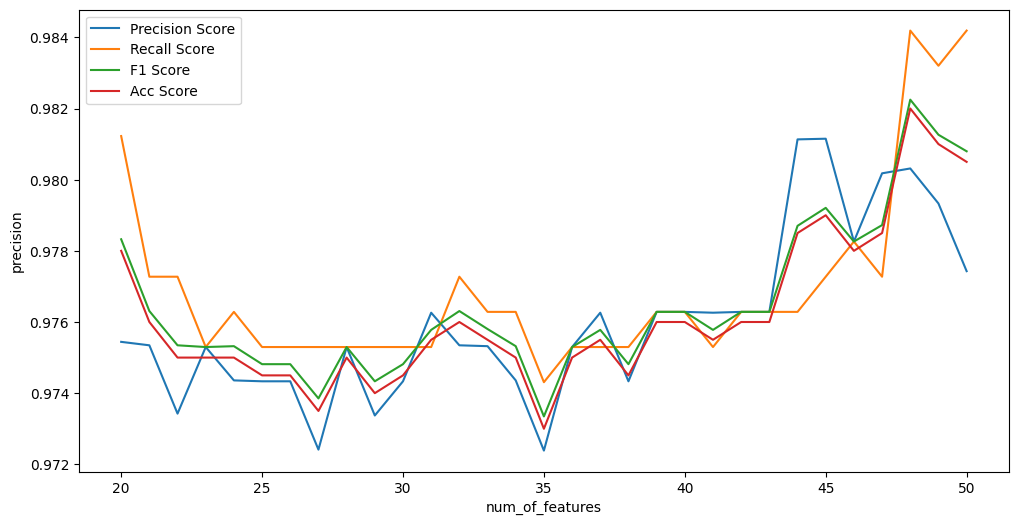

In [35]:
sns.lineplot(x='num_of_features', y='precision', data=df_resultsrf, label='Precision Score')
sns.lineplot(x='num_of_features', y='recall', data=df_resultsrf, label='Recall Score')
sns.lineplot(x='num_of_features', y='f1_score', data=df_resultsrf, label='F1 Score')
sns.lineplot(x='num_of_features', y='accuracy', data=df_resultsrf, label='Acc Score')

In [36]:
# Sort by accuracy in descending order and display the top 3
top_3_resultsrf = df_resultsrf.sort_values('accuracy', ascending=False).head(3)

top_3_resultsrf


,num_of_features,precision,recall,f1_score,accuracy
28,48,0.980315,0.984190,0.982249,0.9820
29,49,0.979331,0.983202,0.981262,0.9810
30,50,0.977429,0.984190,0.980798,0.9805


## Final Random Forest Model

Lets train the final random forest model based on the optimal N number of features

In [37]:
top_n_featuresrf = mi_scores.sort_values(ascending=False).head(48).index.tolist()
X = data[top_n_featuresrf]
y = data['labels']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rfc = cuRfc(n_estimators=500,
            max_depth=32,
            min_samples_leaf=1,
            max_features=1.0)

rfc.fit(X_train, y_train)

y_predrf = rfc.predict(X_test)

# Evaluate the model
accuracy_rf = accuracy_score(y_test, y_predrf)
precision_rf = precision_score(y_test, y_predrf)
recall_rf = recall_score(y_test, y_predrf)
f1_rf = f1_score(y_test, y_predrf)
conf_matrix_rf = confusion_matrix(y_test, y_predrf)
class_report_rf = classification_report(y_test, y_predrf)

# Print the results
print(f'Single Classifier Logistic Regression Original')
print(f'Accuracy: {accuracy_rf}')
print(f'Precision: {precision_rf}')
print(f'Recall: {recall_rf}')
print(f'F1 Score: {f1_rf}')
print(f'Confusion Matrix:')
print(conf_matrix_rf)
print(class_report_rf)

Single Classifier Logistic Regression Original
Accuracy: 0.98
Precision: 0.9783464566929134
Recall: 0.9822134387351779
F1 Score: 0.980276134122288
Confusion Matrix:
[[966  22]
 [ 18 994]]
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       988
           1       0.98      0.98      0.98      1012

    accuracy                           0.98      2000
   macro avg       0.98      0.98      0.98      2000
weighted avg       0.98      0.98      0.98      2000



# **Support Vector Machine (SVM)**
SVM aims to find the hyperplane that best separates the classes (phishing and legitimate). It's powerful for binary classification tasks.

## Train SVM models

In [38]:
from sklearn.svm import SVC

def train_svc(data, top_n):
    top_n_features = mi_scores.sort_values(ascending=False).head(top_n).index.tolist()
    X = data[top_n_features]
    y = data['labels']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    svc = SVC()
    svc.fit(X_train, y_train)

    y_pred = svc.predict(X_test)

    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)

    return precision, recall, f1, accuracy

In [39]:
arrsvc = []
for i in range(20,51,1):
    precision, recall, f1, accuracy = train_svc(data, i)
    print("Performance for Logistic Model with Top {} features is precision : {}, recall : {}, f1 score : {}, accuracy : {}".format(i, precision, recall, f1, accuracy))
    arrsvc.append([i, precision, recall, f1, accuracy])

Performance for Logistic Model with Top 20 features is precision : 0.8271493212669683, recall : 0.9031620553359684, f1 score : 0.8634860651865848, accuracy : 0.8555
Performance for Logistic Model with Top 21 features is precision : 0.8232642019837692, recall : 0.9021739130434783, f1 score : 0.860914662894861, accuracy : 0.8525
Performance for Logistic Model with Top 22 features is precision : 0.824165915238954, recall : 0.9031620553359684, f1 score : 0.8618576143328619, accuracy : 0.8535
Performance for Logistic Model with Top 23 features is precision : 0.824165915238954, recall : 0.9031620553359684, f1 score : 0.8618576143328619, accuracy : 0.8535
Performance for Logistic Model with Top 24 features is precision : 0.8245931283905967, recall : 0.9011857707509882, f1 score : 0.8611898016997167, accuracy : 0.853
Performance for Logistic Model with Top 25 features is precision : 0.825497287522604, recall : 0.9021739130434783, f1 score : 0.8621340887629839, accuracy : 0.854
Performance for 

## Visualize SVM Performance

Our goal is to beat RFC baseline which is

* accuracy = 0.981
* precision = 0.9802
* recall = 0.9822
* f1_score = 0.9812


In [40]:
df_resultssvc = pd.DataFrame(arrsvc, columns=['num_of_features', 'precision', 'recall', 'f1_score', 'accuracy'])

<Axes: xlabel='num_of_features', ylabel='precision'>

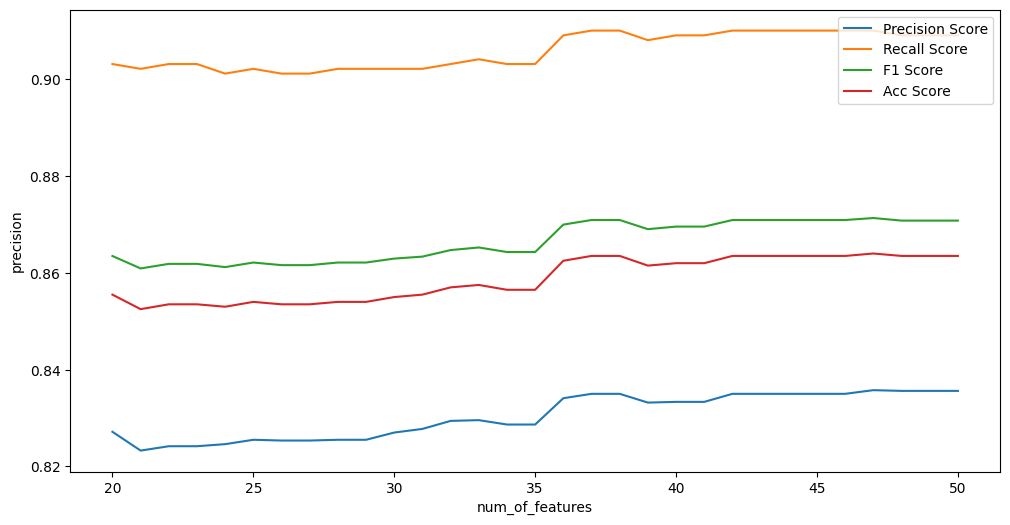

In [41]:
sns.lineplot(x='num_of_features', y='precision', data=df_resultssvc, label='Precision Score')
sns.lineplot(x='num_of_features', y='recall', data=df_resultssvc, label='Recall Score')
sns.lineplot(x='num_of_features', y='f1_score', data=df_resultssvc, label='F1 Score')
sns.lineplot(x='num_of_features', y='accuracy', data=df_resultssvc, label='Acc Score')

In [42]:
# Sort by accuracy in descending order and display the top 3
top_3_resultssvc = df_resultssvc.sort_values('accuracy', ascending=False).head(3)

top_3_resultssvc


,num_of_features,precision,recall,f1_score,accuracy
27,47,0.835753,0.910079,0.871334,0.8640
30,50,0.835604,0.909091,0.870800,0.8635
24,44,0.834995,0.910079,0.870922,0.8635


## Final SVM Model

Lets train the final svm model based on the optimal N number of features

In [44]:
top_n_featuressvc = mi_scores.sort_values(ascending=False).head(47).index.tolist()
X = data[top_n_featuressvc]
y = data['labels']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

svc = SVC()

svc.fit(X_train, y_train)

y_predsvm = svc.predict(X_test)

# Evaluate the model
accuracy_svm = accuracy_score(y_test, y_predsvm)
precision_svm = precision_score(y_test, y_predsvm)
recall_svm = recall_score(y_test, y_predsvm)
f1_svm = f1_score(y_test, y_predsvm)
conf_matrix_svm = confusion_matrix(y_test, y_predsvm)
class_report_svm = classification_report(y_test, y_predsvm)

# Print the results
print(f'Single Classifier Logistic Regression Original')
print(f'Accuracy: {accuracy_svm}')
print(f'Precision: {precision_svm}')
print(f'Recall: {recall_svm}')
print(f'F1 Score: {f1_svm}')
print(f'Confusion Matrix:')
print(conf_matrix_svm)
print(class_report_svm)

Single Classifier Logistic Regression Original
Accuracy: 0.864
Precision: 0.8357531760435571
Recall: 0.9100790513833992
F1 Score: 0.8713339640491958
Confusion Matrix:
[[807 181]
 [ 91 921]]
              precision    recall  f1-score   support

           0       0.90      0.82      0.86       988
           1       0.84      0.91      0.87      1012

    accuracy                           0.86      2000
   macro avg       0.87      0.86      0.86      2000
weighted avg       0.87      0.86      0.86      2000



# Performance

The model is now capable of predicting at up to 98% accuracy and also precision and recall, this shows the model has high confidence in predicting phishing or non-phishing site

In [46]:
performance_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'SVM'],
    'Accuracy': [accuracy_lr, accuracy_rf, accuracy_svm],
    'Precision': [precision_lr, precision_rf, precision_svm],
    'Recall': [recall_lr, recall_rf, recall_svm],
    'F1 Score': [f1_lr, f1_rf, f1_svm]
})

# Sort by accuracy in descending order
performance_df = performance_df.sort_values('Accuracy', ascending=False)

print(performance_df)


                 Model  Accuracy  Precision    Recall  F1 Score
1        Random Forest    0.9800   0.978346  0.982213  0.980276
0  Logistic Regression    0.9395   0.932105  0.949605  0.940773
2                  SVM    0.8640   0.835753  0.910079  0.871334


In [52]:

def extract_features_from_url(url):
  """
  This function is a placeholder for your URL feature extraction logic.
  You'll need to implement the actual feature extraction based on your dataset's features.

  For example, you might want to check for the presence of specific keywords,
  the length of the URL, the use of HTTPS, the presence of IP addresses, etc.
  """
  features = [0] * 48 # Replace with your actual feature count
  # Implement your URL feature extraction logic here
  # ...

  return features

def predict_phishing(url, model):
  """
  Predicts whether a URL is phishing based on the given model.
  """
  features = extract_features_from_url(url)
  prediction = model.predict([features])
  return prediction[0]

# Example usage:
url_to_test = "http://paypa1-verification.com/login" # Replace with your own URL

prediction = predict_phishing(url_to_test, rfc)  # Assuming rfc is your Random Forest model

if prediction == 1:
  print(f"The URL '{url_to_test}' is predicted to be a phishing site.")
else:
  print(f"The URL '{url_to_test}' is predicted to be a legitimate site.")



The URL 'http://paypa1-verification.com/login' is predicted to be a legitimate site.


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
